# Exploring Biased Data via Penguins

Many popular machine algorithms are affected by issues of bias. For example, facial recognition algorithms often work better on people with lighter skin than on people with darker skin. The potential harm is massive. For example, someone could be wrongly arrested because of faulty facial recognition. 

There are many possible sources of these issues, but one well-understood issue is that machine learning models are typically trained on majority white datasets.

In today's lecture, we will illustrate the potential harms of this via penguins.

## Introduction

To start with, we are going to do a modified version of Discussion 14. The difference is that we will be predicting the `Sex` of the penguin rather than the species.

Let's begin by importing all the libraries we'll need, and by downloading the penguins dataset:

*If you experience `ConnectionRefused` errors when doing this, instead copy/paste the url into your browser. Save the data in the same directory as this notebook in a file called `penguins.csv`, and then replace `url` with `"penguins.csv"` in the block below.* 

In [68]:
#import needed libraries and read in data
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import tree, preprocessing
import numpy as np
url = "https://philchodrow.github.io/PIC16A/datasets/palmer_penguins.csv"
penguins = pd.read_csv(url)

### §1. Preparing your data

For this activity, we will use only the following columns: `"Species"`, `"Flipper Length (mm)"`, `"Body Mass (g)"`, `"Sex"`. (Use the square brackets operator on the list of these strings, and **assign the result back to `penguins`.**)

In [69]:
#drop nans and one row where the sex was not recorded
penguins = penguins[['Species', 'Flipper Length (mm)', 'Body Mass (g)', "Sex"]]
penguins = penguins.dropna()
penguins=penguins[penguins["Sex"]!="."]
penguins

,Species,Flipper Length (mm),Body Mass (g),Sex
0,Adelie Penguin (Pygoscelis adeliae),181.0,3750.0,MALE
1,Adelie Penguin (Pygoscelis adeliae),186.0,3800.0,FEMALE
2,Adelie Penguin (Pygoscelis adeliae),195.0,3250.0,FEMALE
4,Adelie Penguin (Pygoscelis adeliae),193.0,3450.0,FEMALE
5,Adelie Penguin (Pygoscelis adeliae),190.0,3650.0,MALE
...,...,...,...,...
338,Gentoo penguin (Pygoscelis papua),214.0,4925.0,FEMALE
340,Gentoo penguin (Pygoscelis papua),215.0,4850.0,FEMALE
341,Gentoo penguin (Pygoscelis papua),222.0,5750.0,MALE
342,Gentoo penguin (Pygoscelis papua),212.0,5200.0,FEMALE


# Training a model the same way as in Discussion

Run the next cell. Doing this will make sure that the random values that your code will generate will be the same every time you run the code.

In [70]:
np.random.seed(3354354524)

In [71]:
from sklearn import preprocessing

le=preprocessing.LabelEncoder()

def prep_data(df):


    X = df.drop(['Sex'], axis = 1)
    y = df['Sex']
 
    le = preprocessing.LabelEncoder()
    X['Species'] = le.fit_transform(X['Species'])
    y = le.fit_transform(y)
    return X,y

X,y=prep_data(penguins)

To make sure that you know what is going on, look at your `X` and `y` variables by running the next cells.

In [72]:
#X

In [73]:
#y

Now split `X` and `y` into training and test data (80/20% of the rows).

**Note**: *You should conduct all splits using a single call to the function `train_test_split` from `sklearn.model_selection`.* You can achieve this by supplying two arrays to this function, as illustrated in the [second example here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html).

In [74]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [75]:
T = tree.DecisionTreeClassifier(max_depth=3)
T.fit(X_train, y_train)
T.score(X_train, y_train), T.score(X_test, y_test)

(0.8834586466165414, 0.835820895522388)

# Biased Data

## What if the training data was nearly all Adelie penguins?

To help answer this, let's split up the data into three smaller data frames. One for each species

In [76]:
just_A=penguins[penguins["Species"]=="Adelie Penguin (Pygoscelis adeliae)"]
just_C=penguins[penguins["Species"]=="Chinstrap penguin (Pygoscelis antarctica)"]
just_G=penguins[penguins["Species"]=="Gentoo penguin (Pygoscelis papua)"]

Now, lets grab test data from each of those columns. I am being a bit lazy and not using a random split here. (Don't imitate this behavior on your project!)

In [77]:
A_samples=60
C_samples=1
G_samples=1

A_train=just_A.iloc[0:A_samples]
C_train=just_C.iloc[0:C_samples]
G_train=just_G.iloc[0:G_samples]

A_test=just_A.iloc[A_samples:]
C_test=just_C.iloc[C_samples:]
G_test=just_G.iloc[G_samples:]



In [78]:
len(A_train),len(C_train),len(G_train)

(60, 1, 1)

In [79]:
len(A_test),len(C_test),len(G_test)

(86, 67, 118)

Now, let's build the total training set and testing set

In [80]:
train=pd.concat([A_train,C_train,G_train])
test=pd.concat([A_test,C_test,G_test])
len(train),len(test)

(62, 271)

In [81]:
X_train,y_train=prep_data(train)
X_test,y_test=prep_data(test)

In [82]:
T = tree.DecisionTreeClassifier(max_depth=2)
T.fit(X_train, y_train)
T.score(X_train, y_train), T.score(X_test, y_test)

(0.8870967741935484, 0.6125461254612546)

In [83]:
preds=T.predict(X_test)
(preds==y_test).mean()

0.6125461254612546

In [84]:
def score_on_subset(subset):

    subset_X = subset.drop(['Sex'], axis = 1)
    subset_y = subset['Sex']
 
    subset_X['Species'] = le.fit_transform(subset_X['Species'])
    subset_y = le.fit_transform(subset_y)

    subset_preds=T.predict(subset_X)
    return (subset_preds==subset_y).mean()




In [85]:
print("Adelie score: " + str(score_on_subset(A_test)))
print("Chinstrap score: " + str(score_on_subset(C_test)))
print("Gentoo score: " + str(score_on_subset(G_test)))

Adelie score: 0.8023255813953488
Chinstrap score: 0.6119402985074627
Gentoo score: 0.4745762711864407


# Interpreting results 

With `balanced` data our model works worse on Gentoo. Let's try to explore why.

In [44]:
penguins.groupby(["Species","Sex"]).describe()

Flipper Length (mm)  \
                                                               count   
Species                                   Sex                          
Adelie Penguin (Pygoscelis adeliae)       FEMALE                73.0   
                                          MALE                  73.0   
Chinstrap penguin (Pygoscelis antarctica) FEMALE                34.0   
                                          MALE                  34.0   
Gentoo penguin (Pygoscelis papua)         FEMALE                58.0   
                                          MALE                  61.0   

                                                                               \
                                                        mean       std    min   
Species                                   Sex                                   
Adelie Penguin (Pygoscelis adeliae)       FEMALE  187.794521  5.595035  172.0   
                                          MALE    192.410959  6.599317  178.0   
Chinstrap penguin (Pygoscelis antarctica) FEMALE  191.735294  5.754096  178.0   
                                          MALE    199.911765  5.976558  187.0   
Gentoo penguin (Pygoscelis papua)         FEMALE  212.706897  3.897856  203.0   
                                          MALE    221.540984  5.673252  208.0   

                                                                         \
                                                     25%    50%     75%   
Species                                   Sex                             
Adelie Penguin (Pygoscelis adeliae)       FEMALE  185.00  188.0  191.00   
                                          MALE    189.00  193.0  197.00   
Chinstrap penguin (Pygoscelis antarctica) FEMALE  187.25  192.0  195.75   
                                          MALE    196.00  200.5  203.00   
Gentoo penguin (Pygoscelis papua)         FEMALE  210.00  212.0  215.00   
                                          MALE    218.00  221.0  225.00   

                                                        Body Mass (g)  \
                                                    max         count   
Species                                   Sex                           
Adelie Penguin (Pygoscelis adeliae)       FEMALE  202.0          73.0   
                                          MALE    210.0          73.0   
Chinstrap penguin (Pygoscelis antarctica) FEMALE  202.0          34.0   
                                          MALE    212.0          34.0   
Gentoo penguin (Pygoscelis papua)         FEMALE  222.0          58.0   
                                          MALE    231.0          61.0   

                                                                           \
                                                         mean         std   
Species                                   Sex                               
Adelie Penguin (Pygoscelis adeliae)       FEMALE  3368.835616  269.380102   
                                          MALE    4043.493151  346.811553   
Chinstrap penguin (Pygoscelis antarctica) FEMALE  3527.205882  285.333912   
                                          MALE    3938.970588  362.137550   
Gentoo penguin (Pygoscelis papua)         FEMALE  4679.741379  281.578294   
                                          MALE    5484.836066  313.158596   

                                                                           \
                                                     min      25%     50%   
Species                                   Sex                               
Adelie Penguin (Pygoscelis adeliae)       FEMALE  2850.0  3175.00  3400.0   
                                          MALE    3325.0  3800.00  4000.0   
Chinstrap penguin (Pygoscelis antarctica) FEMALE  2700.0  3362.50  3550.0   
                                          MALE    3250.0  3731.25  3950.0   
Gentoo penguin (Pygoscelis papua)         FEMALE  3950.0  4462.50  4700.0   
                          

We can see that Gentoo's are bigger than the other two species. Perhaps our classifier is seeing that a Gentoo is big and assuming that it is a male

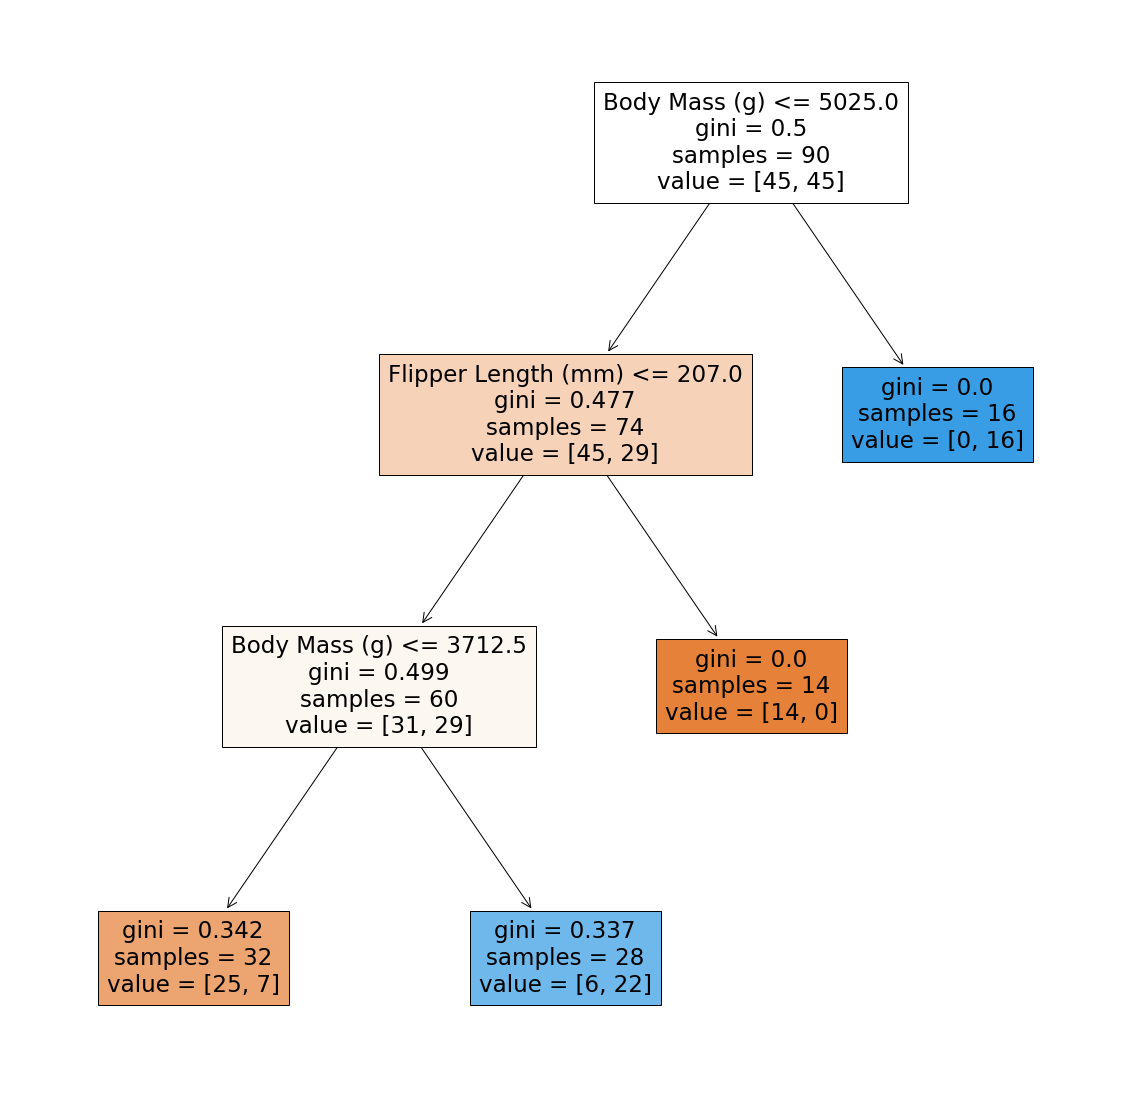

In [45]:
fig, ax = plt.subplots(1, figsize = (20, 20))
p = tree.plot_tree(T, filled = True, feature_names = X.columns)